In [1]:
import os
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

In [2]:
DATA_PATH = os.path.join("..", "data", "raw", "creditcard.csv")
df = pd.read_csv(DATA_PATH)

print("shape:", df.shape)
df.head()

shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
expected_cols = ["Time"] + [f"V{i}" for i in range(1, 29)] + ["Amount", "Class"]
missing_cols = [c for c in expected_cols if c not in df.columns]
extra_cols = [c for c in df.columns if c not in expected_cols]

print("Missing expected columns:", missing_cols)
print("Unexpected extra columns:", extra_cols)

print("\nDtypes:")
display(df.dtypes)

# Gate: Class values should be 0/1 only
unique_class = sorted(df["Class"].unique())
print("\nUnique Class values:", unique_class)

if unique_class != [0, 1]:
    raise ValueError(f"GO/NO-GO: Unexpected Class values: {unique_class}")

Missing expected columns: []
Unexpected extra columns: []

Dtypes:


Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


Unique Class values: [np.int64(0), np.int64(1)]


In [7]:
missing = df.isna().mean().sort_values(ascending=False)
missing_df = missing.to_frame("missing_rate")
display(missing_df.head(20))

dup_count = df.duplicated().sum()
print("Duplicate rows (before dedup):", dup_count)

# ✅ 重複があれば先に除去（ここが重要🔥）
if dup_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Deduplicated: removed {dup_count} rows")
    print("New shape:", df.shape)

# 再チェック
dup_count_after = df.duplicated().sum()
print("Duplicate rows (after dedup):", dup_count_after)

# Gate checks
MAX_MISSING_RATE = 0.0
MAX_DUPLICATE_ROWS = 0

if missing.max() > MAX_MISSING_RATE:
    raise ValueError(f"GO/NO-GO: Missing rate too high. Max={missing.max():.4f}")

if dup_count_after > MAX_DUPLICATE_ROWS:
    raise ValueError(f"GO/NO-GO: Too many duplicates remain. dup_count={dup_count_after}")

,missing_rate
Time,0.0
V16,0.0
Amount,0.0
V28,0.0
V27,0.0
V26,0.0
V25,0.0
V24,0.0
V23,0.0
V22,0.0


Duplicate rows (before dedup): 0
Duplicate rows (after dedup): 0


## Class Imbalance

In [8]:
class_counts = df["Class"].value_counts().sort_index()
class_rates = df["Class"].value_counts(normalize=True).sort_index()

summary = pd.DataFrame({
    "count": class_counts,
    "rate": class_rates
})

summary.index = ["non_fraud (0)", "fraud (1)"]
display(summary)

fraud_rate = class_rates.loc[1]
print(f"Fraud rate: {fraud_rate:.6%}")

,count,rate
non_fraud (0),283253,0.998333
fraud (1),473,0.001667


Fraud rate: 0.166710%


## PM Risk Interpretation: Extreme Class Imbalance

Fraud represents only **0.17%** of transactions.

Operational implications:

- Accuracy is misleading and unusable
- Precision / Recall dominate evaluation
- Threshold selection becomes a business decision
- False negatives → financial risk exposure
- False positives → operational inefficiency / customer friction

Decision:

Model evaluation must prioritize:
- Recall (risk capture)
- Precision (ops cost control)
- PR-AUC (imbalance robustness)


In [9]:
df[["Amount"]].describe(percentiles=[0.5, 0.9, 0.95, 0.99, 0.999]).T

,count,mean,std,min,50%,90%,95%,99%,99.9%,max
Amount,283726.0,88.472687,250.399437,0.0,22.0,203.38,365.3375,1018.965,3004.752,25691.16


## Visual Distribution Check

<Axes: >

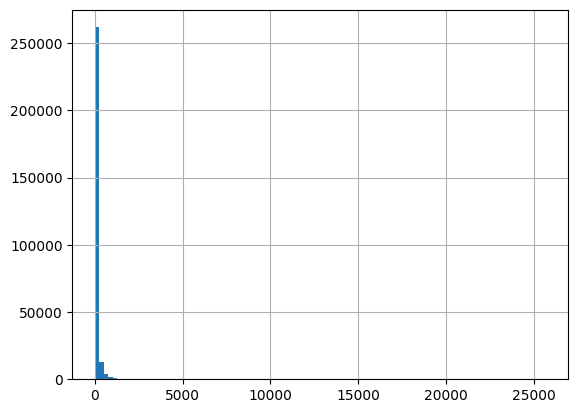

In [10]:
df["Amount"].hist(bins=100)

## PM Risk Interpretation: Transaction Amount Distribution

Transaction amounts exhibit a highly skewed long-tail distribution.

Key observations:

- Mean (88) significantly exceeds median (22)
- Extreme high-value transactions exist (max > 25,000)
- Rare high-impact events dominate statistical behavior

Operational implications:

- Model predictions may become unstable in high-value zones
- Threshold sensitivity increases under distributional shifts
- Drift detection must prioritize Amount feature monitoring
- Outlier handling strategy becomes critical

Decision:

Amount requires:
- Robust scaling / transformation consideration
- Drift baseline establishment
- Segment-specific performance monitoring

In [12]:
df.groupby("Class")["Amount"].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,283253.0,88.413575,250.379023,0.0,5.67,22.00,77.46,25691.16
1,473.0,123.871860,260.211041,0.0,1.00,9.82,105.89,2125.87


## PM Risk Interpretation: Fraud vs Transaction Amount

Fraudulent transactions do NOT concentrate exclusively in high-value ranges.

Key observations:

- Fraud mean > Non-fraud mean
- Fraud median < Non-fraud median 💥
- Extreme high-value transactions are mostly non-fraud 💥

Operational implications:

- High-value filtering alone is ineffective
- Threshold strategies based purely on Amount are unsafe
- Fraud detection must rely on multi-feature patterns
- False positive risk increases in high-value zones
- Low-value fraud risk remains significant

Decision:

Monitoring & modeling strategy must include:

✔ Multi-feature interaction analysis  
✔ Threshold tradeoff modeling  
✔ Drift monitoring on Amount & PCA features  
✔ Segment-aware performance evaluation

In [14]:
df["Amount"].sort_values(ascending=False).head(10)

273745    25691.16
58220     19656.53
150705    18910.00
46641     12910.93
53784     11898.09
168820    11789.84
283168    10199.44
227081    10000.00
74408      8790.26
244563     8787.00
Name: Amount, dtype: float64

In [15]:
df.groupby("Class")["Amount"].quantile([0.9, 0.99, 0.999])

Class       
0      0.900     203.00000
       0.990    1018.05760
       0.999    3012.92544
1      0.900     348.65200
       0.990    1364.13680
       0.999    1976.62832
Name: Amount, dtype: float64

## PM Risk Interpretation: Extreme Transaction Values

Transaction Amount contains extreme outliers.

Key observations:

- Maximum transaction exceeds 25,000
- Extreme values are orders of magnitude larger than median
- Rare high-impact events dominate variance structure

Operational implications:

- Prediction instability risk increases
- Threshold sensitivity becomes critical
- Drift detection must prioritize Amount monitoring
- False positive cost spikes in extreme zones
- Business risk if thresholds are poorly calibrated

Decision:

Amount feature requires:

✔ Robust scaling strategy  
✔ Outlier-aware modeling  
✔ Drift baseline monitoring  
✔ Segment-specific threshold analysis

## Quantile Risk Segmentation

In [17]:
df.groupby("Class")["Amount"].quantile([0.90, 0.99, 0.999])

Class       
0      0.900     203.00000
       0.990    1018.05760
       0.999    3012.92544
1      0.900     348.65200
       0.990    1364.13680
       0.999    1976.62832
Name: Amount, dtype: float64

## PM Risk Interpretation: Quantile-Based Risk Zones

Transaction Amount distributions overlap heavily between fraud and non-fraud classes.

Key observations:

- Fraud transactions skew higher, but overlap significantly
- High-value transactions are predominantly legitimate
- No clean separation threshold exists

Operational implications:

- Threshold selection is a business decision, not purely statistical
- False positive vs false negative tradeoff must be modeled
- Segment-aware monitoring required
- Drift impact amplified in high-variance regions

Decision Framework:

Threshold strategy must incorporate:

✔ Business cost modeling  
✔ Precision / Recall tradeoff  
✔ Quantile-aware segmentation  
✔ Drift monitoring sensitivity  
✔ Operational tolerance limits

## Risk Segmentation View

In [18]:
df["Amount_band"] = pd.qcut(df["Amount"], q=10, duplicates="drop")

band_analysis = df.groupby("Amount_band")["Class"].agg(["count", "mean"])
band_analysis.columns = ["transactions", "fraud_rate"]

display(band_analysis)

/var/folders/0z/cflr9ht13_gf2k7pv6b2gzj80000gn/T/ipykernel_8722/3081086050.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_analysis = df.groupby("Amount_band")["Class"].agg(["count", "mean"])


,transactions,fraud_rate
Amount_band,,
"(-0.001, 1.0]",30331,0.005638
"(1.0, 3.58]",26662,0.000975
"(3.58, 8.92]",28222,0.001276
"(8.92, 13.04]",28276,0.000460
"(13.04, 22.0]",28484,0.000492
"(22.0, 37.07]",28271,0.000566
"(37.07, 59.9]",28521,0.000806
"(59.9, 100.0]",28560,0.001716
"(100.0, 203.38]",28027,0.001534


## PM Risk Interpretation: Fraud Density by Amount Segments

Fraud risk is NOT concentrated solely in high-value transactions.

Key observations:

- Lowest transaction band exhibits the highest fraud rate 💥
- Fraudsters frequently exploit low-value transactions
- High-value transactions remain predominantly legitimate
- Risk distribution is multi-modal

Operational implications:

- High-value filtering strategy is insufficient
- Low-value transaction monitoring is critical
- Threshold policies must be segment-aware
- Fraud detection strategy must consider behavioral patterns
- Drift impact may differ by transaction segment

Decision Framework:

Monitoring & Alerting Strategy:

✔ Low-value anomaly detection priority  
✔ High-value false positive mitigation  
✔ Segment-specific thresholds  
✔ Drift sensitivity segmentation  
✔ Risk-weighted alert policies

## Monitoring KPI Desigm

In [19]:
band_analysis["risk_index"] = band_analysis["fraud_rate"] / band_analysis["fraud_rate"].mean()

display(band_analysis.sort_values("risk_index", ascending=False))

,transactions,fraud_rate,risk_index
Amount_band,,,
"(-0.001, 1.0]",30331,0.005638,3.447710
"(203.38, 25691.16]",28372,0.002890,1.767442
"(59.9, 100.0]",28560,0.001716,1.049202
"(100.0, 203.38]",28027,0.001534,0.938238
"(3.58, 8.92]",28222,0.001276,0.780074
"(1.0, 3.58]",26662,0.000975,0.596351
"(37.07, 59.9]",28521,0.000806,0.493156
"(22.0, 37.07]",28271,0.000566,0.346099
"(13.04, 22.0]",28484,0.000492,0.300572


## PM Risk Interpretation: Risk Index Prioritization

Risk segmentation reveals non-uniform fraud distribution.

Key findings:

- Lowest Amount band exhibits **3.4x baseline risk**
- High-value transactions show elevated but lower relative risk
- Fraud risk is concentrated in specific behavioral zones

Operational implications:

- Monitoring priorities must be risk-weighted
- Uniform threshold strategies are suboptimal
- Alert systems must incorporate segment-based sensitivity
- Drift impact likely varies by transaction segment
- Resource allocation should prioritize high-risk zones

Decision Framework:

Monitoring Strategy:

✔ Risk-index driven alert prioritization  
✔ Segment-specific threshold calibration  
✔ Drift detection per risk zone  
✔ Operational load balancing  
✔ Cost-sensitive intervention policies